# EDA of a Multivariate Time Series

**Approximate Learning time:** Up to 45 minutes

---

A multivariate time series consists of several time series, potentially with dependencies across different dimensions. While you can apply the EDA methods used for univariate time series to analyze individual series, it becomes cumbersome when dealing with many time series. In such cases, tools that allow for a comparative analysis across multiple time series become more useful. These techniques will be the focus of this tutorial.

Specifically, we will cover:

- **Raw Data Visualization & Summarization**: A quick glance at the raw data is always helpful.
- **Correlation Matrix**: This time, we are interested in the correlation between different time series. Note that this is not autocorrelation, as we are looking to understand whether two time series are linearly related at the same time step, without considering any lags. Hence, these are simple correlations between the time series variables.
- **Distance Between Time Series**: A more fine-grained pairwise analysis involves identifying similar patterns across time series. These patterns can then be used to measure distances between various time series using specific dissimilarity metrics.

--- 


## Detour: Dataset

In this notebook, we will use **Exchange Rate Dataset**, which contains daily exchange rates from 1990 to 2016 for eight countries: Australia, Britain, Canada, Switzerland, China, Japan, New Zealand, and Singapore. This dataset includes eight univariate time series, totaling 7,588 time steps.

---

### Setup

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import sys; sys.path.append("../")
import utils_tfb # contains the function to read/preprocess the datasets as provided by the authors

TS_DATA_FOLDER = pathlib.Path("../forecasting").resolve() # Data folder

exchange_rate_dataset = TS_DATA_FOLDER / "Exchange.csv"
exchange_rate_data = utils_tfb.read_data(str(exchange_rate_dataset))
print("Dataset shape:", exchange_rate_data.shape)
exchange_rate_data.head()

Dataset shape: (7588, 8)


,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


---

## Raw data Visualization


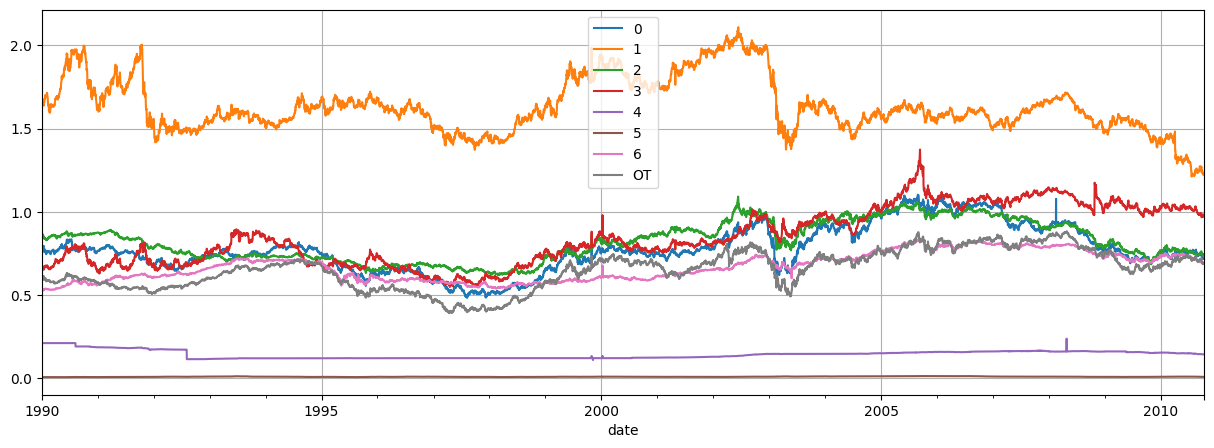

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
exchange_rate_data.plot(ax=ax)
ax.grid()

**Observations:**
- Country 1, Countries 4 and 5, and the rest of countries probably form a cluster together 
- Country 3 might have an overall upward trend, rest of the cotunres seem realtively stable
- There seems to be a lot of seasonal variations 
- Countries 4 and 5 seem relatively stable, but that's because the scale of the plot. Let's plot only Country 5.

---

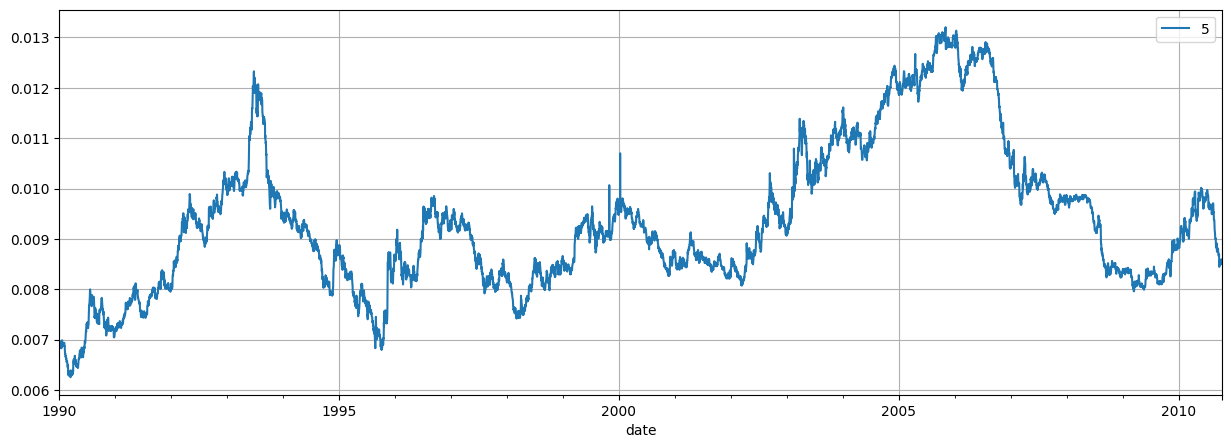

In [3]:
# plot only country 5
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
exchange_rate_data[['5']].plot(ax=ax)
ax.grid()

--- 

## Summarization: Descriptive statistics

The descriptive statistics can easily highlight the differences in scales of various time series.


In [4]:
exchange_rate_data.describe()

,0,1,2,3,4,5,6,OT
count,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000
mean,0.776974,1.634105,0.821811,0.848146,0.142833,0.009343,0.669673,0.654418
std,0.136620,0.161544,0.117123,0.168874,0.023996,0.001458,0.082836,0.115292
min,0.483297,1.211534,0.618582,0.548617,0.109292,0.006254,0.523834,0.393153
25%,0.701422,1.532887,0.727901,0.696864,0.120814,0.008331,0.593287,0.566000
50%,0.761377,1.606574,0.811582,0.813959,0.145212,0.009151,0.662767,0.669187
75%,0.873477,1.707646,0.920394,1.014018,0.159948,0.009995,0.731835,0.734901
max,1.102536,2.109000,1.091524,1.374079,0.237954,0.013202,0.832556,0.882379


--- 

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

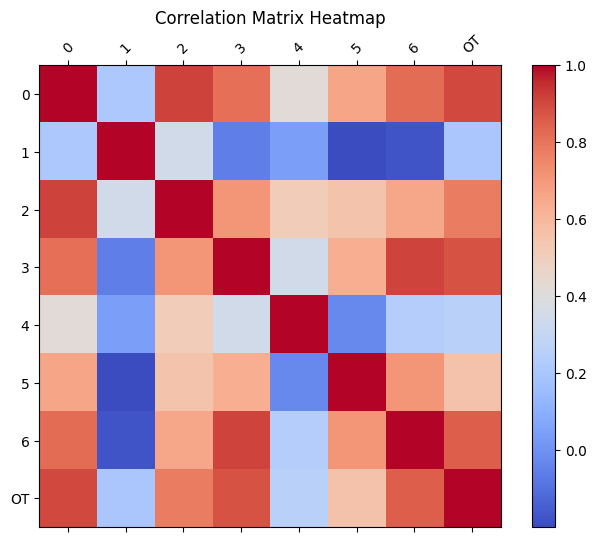

In [5]:
# Correlation matrix plot
correlation_matrix = exchange_rate_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))  # Size of the figure
cax = ax.matshow(correlation_matrix, cmap='coolwarm')  # Create a matrix plot with a color map

ax.set_xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
ax.set_yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

fig.colorbar(cax)

ax.set_title("Correlation Matrix Heatmap")


**Observation**

- Countries 1 and 4 seems to be uncorrelated to most of the time series 

--- 

## Distance Between Time Series

One common metric to compute the distance between time series is DTW - [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). An optimal alignment between two time series is found by the algorithm that minimizes the warp path between the two time series. Refer to Salvador and Chan for more details. These [tutorial slides](https://www.cs.unm.edu/~mueen/DTW.pdf) are also an excellent source.

In Python, you can use the `fastdtw` library ([GitHub Repository](https://github.com/slaypni/fastdtw)) to compute these distances efficiently. Let’s calculate the distances between the time series in the exchange rate dataset. This step may take 10-20 seconds. 

**References**

[(Salvador and Chan), FastDTW: Toward Accurate Dynamic Time Warping in Linear Time and Space](https://cs.fit.edu/~pkc/papers/tdm04.pdf)

Text(0.5, 1.0, 'DTW distances')

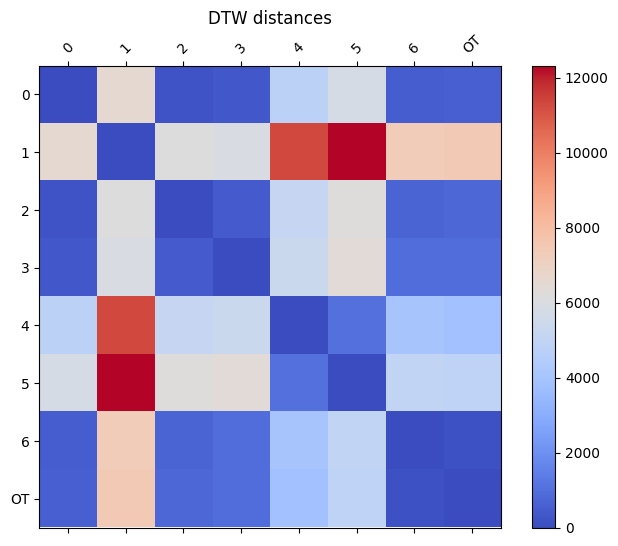

In [6]:
n_series = len(exchange_rate_data.columns)
distance_matrix = np.zeros((n_series, n_series))

for i in range(n_series):
    for j in range(i+1, n_series):
        coli = exchange_rate_data.columns[i]
        colj = exchange_rate_data.columns[j]
        distance, _ = fastdtw(exchange_rate_data[coli].values[..., None], exchange_rate_data[colj].values[..., None], dist=euclidean)
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# print("DTW Distance Matrix:")
# print(distance_matrix)

fig, ax = plt.subplots(figsize=(8, 6)) 
cax = ax.matshow(distance_matrix, cmap='coolwarm') 

ax.set_xticks(range(n_series), exchange_rate_data.columns, rotation=45)
ax.set_yticks(range(n_series), exchange_rate_data.columns)

fig.colorbar(cax)

ax.set_title("DTW distances")

**Observation**: As expected from observing the raw data, countries 1, 4&5, and rest of them form a cluster. 


---

## Conclusion 

We explored a few additional techniques for analyzing multivariate time series. Specifically, we examined the correlation matrix and distance metrics between time series. These tools are useful for gaining an overview of a multivariate time series dataset.

--- 


## Next Steps

**Using GluonTS to access datasets:** Proceed to `1.3_gluonts_datasets.ipynb` to explore the GluonTS library, a powerful tool for modeling time series.

---